# Multilayer Perceptron Using Keras and MADlib

E2E classification example using MADlib calling a Keras MLP.

Deep learning works best on very large datasets, but that is not convenient for a quick introduction to the syntax.  So in this workbook we use the well known iris data set from https://archive.ics.uci.edu/ml/datasets/iris to help get you started.  It is similar to the example in user docs http://madlib.apache.org/docs/latest/index.html

For more realistic examples with images please refer to the deep learning notebooks at
https://github.com/apache/madlib-site/tree/asf-site/community-artifacts

## Table of contents

<a href="#class">Classification</a>

* <a href="#create_input_data">1. Create input data</a>

* <a href="#pp">2. Call preprocessor for deep learning</a>

* <a href="#load">3. Define and load model architecture</a>

* <a href="#train">4. Train</a>

* <a href="#eval">5. Evaluate</a>

* <a href="#pred">6. Predict</a>

* <a href="#pred_byom">7. Predict BYOM</a>

<a href="#class2">Classification with Other Parameters</a>

* <a href="#val_dataset">1. Validation dataset</a>

* <a href="#pred_prob">2. Predict probabilities</a>

* <a href="#warm_start">3. Warm start</a>

<a href="#transfer_learn">Transfer learning</a>

* <a href="#load2">1. Define and load model architecture with some layers frozen</a>

* <a href="#train2">2. Train transfer model</a>

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@madlib'

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rel/v1.16-54-gec5614f, cmake configuration time: Wed Dec 18 17:08:05 UTC 2019, build type: release, build system: Linux-3.10.0-1062.4.3.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


<a id="class"></a>
# Classification

<a id="create_input_data"></a>
# 1.  Create input data

Load iris data set.

In [4]:
%%sql 
DROP TABLE IF EXISTS iris_data;

CREATE TABLE iris_data(
    id serial,
    attributes numeric[],
    class_text varchar
);

INSERT INTO iris_data(id, attributes, class_text) VALUES
(1,ARRAY[5.1,3.5,1.4,0.2],'Iris-setosa'),
(2,ARRAY[4.9,3.0,1.4,0.2],'Iris-setosa'),
(3,ARRAY[4.7,3.2,1.3,0.2],'Iris-setosa'),
(4,ARRAY[4.6,3.1,1.5,0.2],'Iris-setosa'),
(5,ARRAY[5.0,3.6,1.4,0.2],'Iris-setosa'),
(6,ARRAY[5.4,3.9,1.7,0.4],'Iris-setosa'),
(7,ARRAY[4.6,3.4,1.4,0.3],'Iris-setosa'),
(8,ARRAY[5.0,3.4,1.5,0.2],'Iris-setosa'),
(9,ARRAY[4.4,2.9,1.4,0.2],'Iris-setosa'),
(10,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(11,ARRAY[5.4,3.7,1.5,0.2],'Iris-setosa'),
(12,ARRAY[4.8,3.4,1.6,0.2],'Iris-setosa'),
(13,ARRAY[4.8,3.0,1.4,0.1],'Iris-setosa'),
(14,ARRAY[4.3,3.0,1.1,0.1],'Iris-setosa'),
(15,ARRAY[5.8,4.0,1.2,0.2],'Iris-setosa'),
(16,ARRAY[5.7,4.4,1.5,0.4],'Iris-setosa'),
(17,ARRAY[5.4,3.9,1.3,0.4],'Iris-setosa'),
(18,ARRAY[5.1,3.5,1.4,0.3],'Iris-setosa'),
(19,ARRAY[5.7,3.8,1.7,0.3],'Iris-setosa'),
(20,ARRAY[5.1,3.8,1.5,0.3],'Iris-setosa'),
(21,ARRAY[5.4,3.4,1.7,0.2],'Iris-setosa'),
(22,ARRAY[5.1,3.7,1.5,0.4],'Iris-setosa'),
(23,ARRAY[4.6,3.6,1.0,0.2],'Iris-setosa'),
(24,ARRAY[5.1,3.3,1.7,0.5],'Iris-setosa'),
(25,ARRAY[4.8,3.4,1.9,0.2],'Iris-setosa'),
(26,ARRAY[5.0,3.0,1.6,0.2],'Iris-setosa'),
(27,ARRAY[5.0,3.4,1.6,0.4],'Iris-setosa'),
(28,ARRAY[5.2,3.5,1.5,0.2],'Iris-setosa'),
(29,ARRAY[5.2,3.4,1.4,0.2],'Iris-setosa'),
(30,ARRAY[4.7,3.2,1.6,0.2],'Iris-setosa'),
(31,ARRAY[4.8,3.1,1.6,0.2],'Iris-setosa'),
(32,ARRAY[5.4,3.4,1.5,0.4],'Iris-setosa'),
(33,ARRAY[5.2,4.1,1.5,0.1],'Iris-setosa'),
(34,ARRAY[5.5,4.2,1.4,0.2],'Iris-setosa'),
(35,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(36,ARRAY[5.0,3.2,1.2,0.2],'Iris-setosa'),
(37,ARRAY[5.5,3.5,1.3,0.2],'Iris-setosa'),
(38,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(39,ARRAY[4.4,3.0,1.3,0.2],'Iris-setosa'),
(40,ARRAY[5.1,3.4,1.5,0.2],'Iris-setosa'),
(41,ARRAY[5.0,3.5,1.3,0.3],'Iris-setosa'),
(42,ARRAY[4.5,2.3,1.3,0.3],'Iris-setosa'),
(43,ARRAY[4.4,3.2,1.3,0.2],'Iris-setosa'),
(44,ARRAY[5.0,3.5,1.6,0.6],'Iris-setosa'),
(45,ARRAY[5.1,3.8,1.9,0.4],'Iris-setosa'),
(46,ARRAY[4.8,3.0,1.4,0.3],'Iris-setosa'),
(47,ARRAY[5.1,3.8,1.6,0.2],'Iris-setosa'),
(48,ARRAY[4.6,3.2,1.4,0.2],'Iris-setosa'),
(49,ARRAY[5.3,3.7,1.5,0.2],'Iris-setosa'),
(50,ARRAY[5.0,3.3,1.4,0.2],'Iris-setosa'),
(51,ARRAY[7.0,3.2,4.7,1.4],'Iris-versicolor'),
(52,ARRAY[6.4,3.2,4.5,1.5],'Iris-versicolor'),
(53,ARRAY[6.9,3.1,4.9,1.5],'Iris-versicolor'),
(54,ARRAY[5.5,2.3,4.0,1.3],'Iris-versicolor'),
(55,ARRAY[6.5,2.8,4.6,1.5],'Iris-versicolor'),
(56,ARRAY[5.7,2.8,4.5,1.3],'Iris-versicolor'),
(57,ARRAY[6.3,3.3,4.7,1.6],'Iris-versicolor'),
(58,ARRAY[4.9,2.4,3.3,1.0],'Iris-versicolor'),
(59,ARRAY[6.6,2.9,4.6,1.3],'Iris-versicolor'),
(60,ARRAY[5.2,2.7,3.9,1.4],'Iris-versicolor'),
(61,ARRAY[5.0,2.0,3.5,1.0],'Iris-versicolor'),
(62,ARRAY[5.9,3.0,4.2,1.5],'Iris-versicolor'),
(63,ARRAY[6.0,2.2,4.0,1.0],'Iris-versicolor'),
(64,ARRAY[6.1,2.9,4.7,1.4],'Iris-versicolor'),
(65,ARRAY[5.6,2.9,3.6,1.3],'Iris-versicolor'),
(66,ARRAY[6.7,3.1,4.4,1.4],'Iris-versicolor'),
(67,ARRAY[5.6,3.0,4.5,1.5],'Iris-versicolor'),
(68,ARRAY[5.8,2.7,4.1,1.0],'Iris-versicolor'),
(69,ARRAY[6.2,2.2,4.5,1.5],'Iris-versicolor'),
(70,ARRAY[5.6,2.5,3.9,1.1],'Iris-versicolor'),
(71,ARRAY[5.9,3.2,4.8,1.8],'Iris-versicolor'),
(72,ARRAY[6.1,2.8,4.0,1.3],'Iris-versicolor'),
(73,ARRAY[6.3,2.5,4.9,1.5],'Iris-versicolor'),
(74,ARRAY[6.1,2.8,4.7,1.2],'Iris-versicolor'),
(75,ARRAY[6.4,2.9,4.3,1.3],'Iris-versicolor'),
(76,ARRAY[6.6,3.0,4.4,1.4],'Iris-versicolor'),
(77,ARRAY[6.8,2.8,4.8,1.4],'Iris-versicolor'),
(78,ARRAY[6.7,3.0,5.0,1.7],'Iris-versicolor'),
(79,ARRAY[6.0,2.9,4.5,1.5],'Iris-versicolor'),
(80,ARRAY[5.7,2.6,3.5,1.0],'Iris-versicolor'),
(81,ARRAY[5.5,2.4,3.8,1.1],'Iris-versicolor'),
(82,ARRAY[5.5,2.4,3.7,1.0],'Iris-versicolor'),
(83,ARRAY[5.8,2.7,3.9,1.2],'Iris-versicolor'),
(84,ARRAY[6.0,2.7,5.1,1.6],'Iris-versicolor'),
(85,ARRAY[5.4,3.0,4.5,1.5],'Iris-versicolor'),
(86,ARRAY[6.0,3.4,4.5,1.6],'Iris-versicolor'),
(87,ARRAY[6.7,3.1,4.7,1.5],'Iris-versicolor'),
(88,ARRAY[6.3,2.3,4.4,1.3],'Iris-versicolor'),
(89,ARRAY[5.6,3.0,4.1,1.3],'Iris-versicolor'),
(90,ARRAY[5.5,2.5,4.0,1.3],'Iris-versicolor'),
(91,ARRAY[5.5,2.6,4.4,1.2],'Iris-versicolor'),
(92,ARRAY[6.1,3.0,4.6,1.4],'Iris-versicolor'),
(93,ARRAY[5.8,2.6,4.0,1.2],'Iris-versicolor'),
(94,ARRAY[5.0,2.3,3.3,1.0],'Iris-versicolor'),
(95,ARRAY[5.6,2.7,4.2,1.3],'Iris-versicolor'),
(96,ARRAY[5.7,3.0,4.2,1.2],'Iris-versicolor'),
(97,ARRAY[5.7,2.9,4.2,1.3],'Iris-versicolor'),
(98,ARRAY[6.2,2.9,4.3,1.3],'Iris-versicolor'),
(99,ARRAY[5.1,2.5,3.0,1.1],'Iris-versicolor'),
(100,ARRAY[5.7,2.8,4.1,1.3],'Iris-versicolor'),
(101,ARRAY[6.3,3.3,6.0,2.5],'Iris-virginica'),
(102,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(103,ARRAY[7.1,3.0,5.9,2.1],'Iris-virginica'),
(104,ARRAY[6.3,2.9,5.6,1.8],'Iris-virginica'),
(105,ARRAY[6.5,3.0,5.8,2.2],'Iris-virginica'),
(106,ARRAY[7.6,3.0,6.6,2.1],'Iris-virginica'),
(107,ARRAY[4.9,2.5,4.5,1.7],'Iris-virginica'),
(108,ARRAY[7.3,2.9,6.3,1.8],'Iris-virginica'),
(109,ARRAY[6.7,2.5,5.8,1.8],'Iris-virginica'),
(110,ARRAY[7.2,3.6,6.1,2.5],'Iris-virginica'),
(111,ARRAY[6.5,3.2,5.1,2.0],'Iris-virginica'),
(112,ARRAY[6.4,2.7,5.3,1.9],'Iris-virginica'),
(113,ARRAY[6.8,3.0,5.5,2.1],'Iris-virginica'),
(114,ARRAY[5.7,2.5,5.0,2.0],'Iris-virginica'),
(115,ARRAY[5.8,2.8,5.1,2.4],'Iris-virginica'),
(116,ARRAY[6.4,3.2,5.3,2.3],'Iris-virginica'),
(117,ARRAY[6.5,3.0,5.5,1.8],'Iris-virginica'),
(118,ARRAY[7.7,3.8,6.7,2.2],'Iris-virginica'),
(119,ARRAY[7.7,2.6,6.9,2.3],'Iris-virginica'),
(120,ARRAY[6.0,2.2,5.0,1.5],'Iris-virginica'),
(121,ARRAY[6.9,3.2,5.7,2.3],'Iris-virginica'),
(122,ARRAY[5.6,2.8,4.9,2.0],'Iris-virginica'),
(123,ARRAY[7.7,2.8,6.7,2.0],'Iris-virginica'),
(124,ARRAY[6.3,2.7,4.9,1.8],'Iris-virginica'),
(125,ARRAY[6.7,3.3,5.7,2.1],'Iris-virginica'),
(126,ARRAY[7.2,3.2,6.0,1.8],'Iris-virginica'),
(127,ARRAY[6.2,2.8,4.8,1.8],'Iris-virginica'),
(128,ARRAY[6.1,3.0,4.9,1.8],'Iris-virginica'),
(129,ARRAY[6.4,2.8,5.6,2.1],'Iris-virginica'),
(130,ARRAY[7.2,3.0,5.8,1.6],'Iris-virginica'),
(131,ARRAY[7.4,2.8,6.1,1.9],'Iris-virginica'),
(132,ARRAY[7.9,3.8,6.4,2.0],'Iris-virginica'),
(133,ARRAY[6.4,2.8,5.6,2.2],'Iris-virginica'),
(134,ARRAY[6.3,2.8,5.1,1.5],'Iris-virginica'),
(135,ARRAY[6.1,2.6,5.6,1.4],'Iris-virginica'),
(136,ARRAY[7.7,3.0,6.1,2.3],'Iris-virginica'),
(137,ARRAY[6.3,3.4,5.6,2.4],'Iris-virginica'),
(138,ARRAY[6.4,3.1,5.5,1.8],'Iris-virginica'),
(139,ARRAY[6.0,3.0,4.8,1.8],'Iris-virginica'),
(140,ARRAY[6.9,3.1,5.4,2.1],'Iris-virginica'),
(141,ARRAY[6.7,3.1,5.6,2.4],'Iris-virginica'),
(142,ARRAY[6.9,3.1,5.1,2.3],'Iris-virginica'),
(143,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(144,ARRAY[6.8,3.2,5.9,2.3],'Iris-virginica'),
(145,ARRAY[6.7,3.3,5.7,2.5],'Iris-virginica'),
(146,ARRAY[6.7,3.0,5.2,2.3],'Iris-virginica'),
(147,ARRAY[6.3,2.5,5.0,1.9],'Iris-virginica'),
(148,ARRAY[6.5,3.0,5.2,2.0],'Iris-virginica'),
(149,ARRAY[6.2,3.4,5.4,2.3],'Iris-virginica'),
(150,ARRAY[5.9,3.0,5.1,1.8],'Iris-virginica');

SELECT * FROM iris_data ORDER BY id;

Done.
Done.
150 rows affected.
150 rows affected.


id,attributes,class_text
1,"[Decimal('5.1'), Decimal('3.5'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
2,"[Decimal('4.9'), Decimal('3.0'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
3,"[Decimal('4.7'), Decimal('3.2'), Decimal('1.3'), Decimal('0.2')]",Iris-setosa
4,"[Decimal('4.6'), Decimal('3.1'), Decimal('1.5'), Decimal('0.2')]",Iris-setosa
5,"[Decimal('5.0'), Decimal('3.6'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
6,"[Decimal('5.4'), Decimal('3.9'), Decimal('1.7'), Decimal('0.4')]",Iris-setosa
7,"[Decimal('4.6'), Decimal('3.4'), Decimal('1.4'), Decimal('0.3')]",Iris-setosa
8,"[Decimal('5.0'), Decimal('3.4'), Decimal('1.5'), Decimal('0.2')]",Iris-setosa
9,"[Decimal('4.4'), Decimal('2.9'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
10,"[Decimal('4.9'), Decimal('3.1'), Decimal('1.5'), Decimal('0.1')]",Iris-setosa


Create a test/validation dataset from the training data

In [5]:
%%sql
DROP TABLE IF EXISTS iris_train, iris_test;

-- Set seed so results are reproducible
SELECT setseed(0);

SELECT madlib.train_test_split('iris_data',     -- Source table
                               'iris',          -- Output table root name
                                0.8,            -- Train proportion
                                NULL,           -- Test proportion (0.2)
                                NULL,           -- Strata definition
                                NULL,           -- Output all columns
                                NULL,           -- Sample without replacement
                                TRUE            -- Separate output tables
                              );

SELECT COUNT(*) FROM iris_train;

Done.
1 rows affected.
1 rows affected.
1 rows affected.


count
120


<a id="pp"></a>
# 2. Call preprocessor for deep learning
Training dataset (uses training preprocessor):

In [6]:
%%sql
DROP TABLE IF EXISTS iris_train_packed, iris_train_packed_summary;

SELECT madlib.training_preprocessor_dl('iris_train',         -- Source table
                                       'iris_train_packed',  -- Output table
                                       'class_text',        -- Dependent variable
                                       'attributes'         -- Independent variable
                                        ); 

SELECT independent_var_shape, dependent_var_shape, buffer_id FROM iris_train_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


independent_var_shape,dependent_var_shape,buffer_id
"[60, 4]","[60, 3]",0
"[60, 4]","[60, 3]",1


In [7]:
%%sql
SELECT * FROM iris_train_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
iris_train,iris_train_packed,class_text,attributes,character varying,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",60,1.0,3,all_segments,all_segments


Validation dataset (uses validation preprocessor):

In [8]:
%%sql
DROP TABLE IF EXISTS iris_test_packed, iris_test_packed_summary;

SELECT madlib.validation_preprocessor_dl('iris_test',          -- Source table
                                         'iris_test_packed',   -- Output table
                                         'class_text',         -- Dependent variable
                                         'attributes',         -- Independent variable
                                         'iris_train_packed'   -- From training preprocessor step
                                          ); 

SELECT independent_var_shape, dependent_var_shape, buffer_id FROM iris_test_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


independent_var_shape,dependent_var_shape,buffer_id
"[15, 4]","[15, 3]",0
"[15, 4]","[15, 3]",1


In [9]:
%%sql
SELECT * FROM iris_test_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
iris_test,iris_test_packed,class_text,attributes,character varying,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",15,1.0,3,all_segments,all_segments


<a id="load"></a>
# 3. Define and load model architecture
Import Keras libraries

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Define model architecture

In [11]:
model_simple = Sequential()
model_simple.add(Dense(10, activation='relu', input_shape=(4,)))
model_simple.add(Dense(10, activation='relu'))
model_simple.add(Dense(3, activation='softmax'))
    
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_simple.to_json()

'{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10,

Load into model architecture table

In [13]:
%%sql
DROP TABLE IF EXISTS model_arch_library;
SELECT madlib.load_keras_model('model_arch_library',  -- Output table,
                               
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Sophie',              -- Name
                               'A simple model'       -- Descr
);

SELECT model_id, model_arch, name, description FROM model_arch_library ORDER BY model_id;

Done.
1 rows affected.
1 rows affected.


model_id,model_arch,name,description
1,"{u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_1', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'dtype': u'float32', u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'batch_input_shape': [None, 4], u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_2', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_3', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'softmax', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}",Sophie,A simple model


<a id="train"></a>
# 4.  Train
Train the model:

In [14]:
%%sql
DROP TABLE IF EXISTS iris_model, iris_model_summary;

SELECT madlib.madlib_keras_fit('iris_train_packed',   -- source table
                               'iris_model',          -- model output table
                               'model_arch_library',  -- model arch table
                                1,                    -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] $$,  -- compile_params
                                $$ batch_size=5, epochs=3 $$,  -- fit_params
                                10                    -- num_iterations
                              );

Done.
1 rows affected.


madlib_keras_fit
""


View the model summary:

In [15]:
%%sql
SELECT * FROM iris_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
iris_train_packed,iris_model,class_text,attributes,model_arch_library,1,"loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']","batch_size=5, epochs=3",10,None,10,None,None,madlib_keras,0.7900390625,2019-12-18 18:09:06.678020,2019-12-18 18:09:09.703493,[3.02539992332458],1.17-dev,3,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",character varying,1.0,[u'accuracy'],0.958333313465,0.619696557522,[0.958333313465118],[0.61969655752182],None,None,None,None,[10]


<a id="eval"></a>
# 5. Evaluate

Now run evaluate using model we built above:

In [16]:
%%sql
DROP TABLE IF EXISTS iris_validate;

SELECT madlib.madlib_keras_evaluate('iris_model',       -- model
                                   'iris_test_packed',  -- test table
                                   'iris_validate'      -- output table
                                   );

SELECT * FROM iris_validate;

Done.
1 rows affected.
1 rows affected.


loss,metric,metrics_type
0.627631247044,0.899999976158,[u'accuracy']


<a id="pred"></a>
# 6. Predict

Now predict using model we built.  We will use the validation data set for prediction as well, which is not usual but serves to show the syntax. The prediction is in the estimated_class_text column:

In [17]:
%%sql
DROP TABLE IF EXISTS iris_predict;

SELECT madlib.madlib_keras_predict('iris_model', -- model
                                   'iris_test',  -- test_table
                                   'id',  -- id column
                                   'attributes', -- independent var
                                   'iris_predict'  -- output table
                                   );

SELECT * FROM iris_predict ORDER BY id;

Done.
1 rows affected.
30 rows affected.


id,estimated_class_text
7,Iris-setosa
8,Iris-setosa
9,Iris-setosa
14,Iris-setosa
18,Iris-setosa
28,Iris-setosa
44,Iris-setosa
48,Iris-setosa
54,Iris-virginica
56,Iris-versicolor


Count missclassifications

In [18]:
%%sql
SELECT COUNT(*) FROM iris_predict JOIN iris_test USING (id) 
WHERE iris_predict.estimated_class_text != iris_test.class_text;

1 rows affected.


count
3


Percent missclassifications

In [19]:
%%sql
SELECT round(count(*)*100/(150*0.2),2) as test_accuracy_percent from
    (select iris_test.class_text as actual, iris_predict.estimated_class_text as estimated
     from iris_predict inner join iris_test
     on iris_test.id=iris_predict.id) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
90.00


<a id="pred_byom"></a>
# 7. Predict BYOM
The predict BYOM function allows you to do inference on models that have not been trained on MADlib, but rather imported from elsewhere.  

We will use the validation dataset for prediction as well, which is not usual but serves to show the syntax.

See load_keras_model()
http://madlib.apache.org/docs/latest/group__grp__keras__model__arch.html
for details on how to load the model architecture and weights.  In this example we will use weights we already have:

In [20]:
%%sql
UPDATE model_arch_library 
SET model_weights = iris_model.model_weights 
FROM iris_model 
WHERE model_arch_library.model_id = 1;

1 rows affected.


[]

Now train using a model from the model architecture table directly without referencing the model table from the MADlib training.  

Note that if you specify the class values parameter as we do below, it must reflect how the dependent variable was 1-hot encoded for training.  In this example the 'training_preprocessor_dl()' in Step 2 above encoded in the order {'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'} so this is the order we pass in the parameter.  If we accidently picked another order that did not match the 1-hot encoding, the predictions would be wrong.

In [21]:
%%sql
DROP TABLE IF EXISTS iris_predict_byom;

SELECT madlib.madlib_keras_predict_byom('model_arch_library',  -- model arch table
                                         1,                    -- model arch id
                                        'iris_test',           -- test_table
                                        'id',                  -- id column
                                        'attributes',          -- independent var
                                        'iris_predict_byom',   -- output table
                                        'response',            -- prediction type
                                         FALSE,                -- use GPUs
                                         ARRAY['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], -- class values
                                         1.0                   -- normalizing const
                                   );
SELECT * FROM iris_predict_byom ORDER BY id;

Done.
1 rows affected.
30 rows affected.


id,estimated_dependent_var
7,Iris-setosa
8,Iris-setosa
9,Iris-setosa
14,Iris-setosa
18,Iris-setosa
28,Iris-setosa
44,Iris-setosa
48,Iris-setosa
54,Iris-virginica
56,Iris-versicolor


Count missclassifications:

In [22]:
%%sql
SELECT COUNT(*) FROM iris_predict_byom JOIN iris_test USING (id)
WHERE iris_predict_byom.estimated_dependent_var != iris_test.class_text;

1 rows affected.


count
3


Percent missclassifications:

In [23]:
%%sql
SELECT round(count(*)*100/(150*0.2),2) as test_accuracy_percent from
    (select iris_test.class_text as actual, iris_predict_byom.estimated_dependent_var as estimated
     from iris_predict_byom inner join iris_test
     on iris_test.id=iris_predict_byom.id) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
90.00


<a id="class2"></a>
# Classification with Other Parameters

<a id="val_dataset"></a>
# 1.  Validation dataset
Now use a validation dataset and compute metrics every 2nd iteration using the 'metrics_compute_frequency' parameter.  This can help reduce run time if you do not need metrics computed at every iteration.

In [24]:
%%sql
DROP TABLE IF EXISTS iris_model, iris_model_summary;

SELECT madlib.madlib_keras_fit('iris_train_packed',   -- source table
                               'iris_model',          -- model output table
                               'model_arch_library',  -- model arch table
                                1,                    -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] $$,  -- compile_params
                                $$ batch_size=5, epochs=3 $$,  -- fit_params
                                10,                   -- num_iterations
                                FALSE,                -- use GPUs
                                'iris_test_packed',   -- validation dataset
                                2,                    -- metrics compute frequency
                                FALSE,                -- warm start
                               'Sophie L.',           -- name
                               'Simple MLP for iris dataset'  -- description
                              );

Done.
1 rows affected.


madlib_keras_fit
""


View the model summary:

In [25]:
%%sql
SELECT * FROM iris_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
iris_train_packed,iris_model,class_text,attributes,model_arch_library,1,"loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']","batch_size=5, epochs=3",10,iris_test_packed,2,Sophie L.,Simple MLP for iris dataset,madlib_keras,0.7900390625,2019-12-18 18:09:19.330964,2019-12-18 18:09:21.010635,"[0.915475130081177, 1.10240316390991, 1.24091100692749, 1.37801814079285, 1.67959213256836]",1.17-dev,3,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",character varying,1.0,[u'accuracy'],0.983333349228,0.308444350958,"[0.949999988079071, 0.975000023841858, 0.975000023841858, 0.983333349227905, 0.983333349227905]","[0.5235316157341, 0.450434356927872, 0.391158282756805, 0.344655215740204, 0.30844435095787]",0.933333337307,0.363271415234,"[0.866666674613953, 0.933333337306976, 0.933333337306976, 0.933333337306976, 0.933333337306976]","[0.549321353435516, 0.490176409482956, 0.438665509223938, 0.397390514612198, 0.363271415233612]","[2, 4, 6, 8, 10]"


Accuracy by iteration

In [26]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

# get accuracy and iteration number
iters_proxy = %sql SELECT metrics_iters FROM iris_model_summary;
train_accuracy_proxy = %sql SELECT training_metrics FROM iris_model_summary;
test_accuracy_proxy = %sql SELECT validation_metrics FROM iris_model_summary;

# get number of points
num_points_proxy = %sql SELECT array_length(metrics_iters,1) FROM iris_model_summary;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
train_accuracy = np.array(train_accuracy_proxy).reshape(num_points)
test_accuracy = np.array(test_accuracy_proxy).reshape(num_points)

#plot
plt.title('Iris validation accuracy by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(iters, train_accuracy, 'g.-', label='Train')
plt.plot(iters, test_accuracy, 'r.-', label='Test')
plt.legend()

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


Loss by iteration

1 rows affected.
1 rows affected.


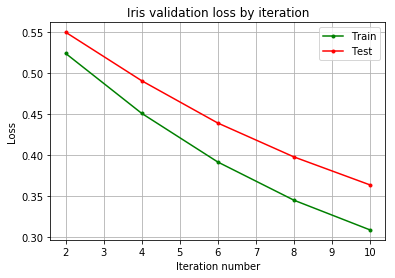

In [27]:
# get loss
train_loss_proxy = %sql SELECT training_loss FROM iris_model_summary;
test_loss_proxy = %sql SELECT validation_loss FROM iris_model_summary;

# reshape to np arrays
train_loss = np.array(train_loss_proxy).reshape(num_points)
test_loss = np.array(test_loss_proxy).reshape(num_points)

#plot
plt.title('Iris validation loss by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(iters, train_loss, 'g.-', label='Train')
plt.plot(iters, test_loss, 'r.-', label='Test')
plt.legend()

Accuracy by time

1 rows affected.


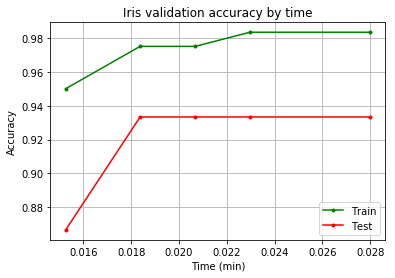

In [28]:
# get time
time_proxy = %sql SELECT metrics_elapsed_time FROM iris_model_summary;

# reshape to np arrays
time = np.array(time_proxy).reshape(num_points)/60.0

#plot
plt.title('Iris validation accuracy by time')
plt.xlabel('Time (min)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(time, train_accuracy, 'g.-', label='Train')
plt.plot(time, test_accuracy, 'r.-', label='Test')
plt.legend()

Time to achieve a given accuracy

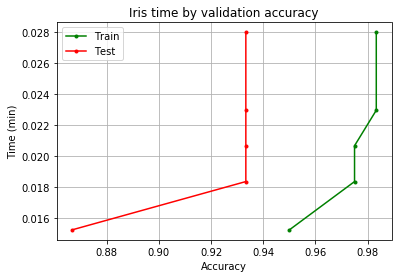

In [29]:
#plot
plt.title('Iris time by validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Time (min)')
plt.grid(True)
plt.plot(train_accuracy, time, 'g.-', label='Train')
plt.plot(test_accuracy, time, 'r.-', label='Test')
plt.legend()

<a id="pred_prob"></a>
# 2. Predict probabilities
Predict with probabilities for each class:

In [30]:
%%sql
DROP TABLE IF EXISTS iris_predict;

SELECT madlib.madlib_keras_predict('iris_model',      -- model
                                   'iris_test',       -- test_table
                                   'id',              -- id column
                                   'attributes',      -- independent var
                                   'iris_predict',    -- output table
                                   'prob'             -- response type
                                   );

SELECT * FROM iris_predict ORDER BY id;

Done.
1 rows affected.
30 rows affected.


id,prob_Iris-setosa,prob_Iris-versicolor,prob_Iris-virginica
7,0.89789814,0.0880069,0.014094983
8,0.90666765,0.081442654,0.011889744
9,0.8795763,0.1017618,0.018661851
14,0.8874597,0.095630445,0.016909808
18,0.9102227,0.078691445,0.011085836
28,0.9124432,0.077006854,0.010549883
44,0.90255314,0.08451119,0.012935703
48,0.89486533,0.09027297,0.014861753
54,0.026524143,0.51825184,0.45522407
56,0.020466398,0.538594,0.4409396


<a id="warm_start"></a>
# 3. Warm start
Next, use the warm_start parameter to continue learning, using the coefficients from the run above. Note that we don't drop the model table or model summary table:

In [31]:
%%sql
SELECT madlib.madlib_keras_fit('iris_train_packed',   -- source table
                               'iris_model',          -- model output table
                               'model_arch_library',  -- model arch table
                                1,                    -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] $$,  -- compile_params
                                $$ batch_size=5, epochs=3 $$,  -- fit_params
                                10,                   -- num_iterations
                                FALSE,                -- use GPUs
                                'iris_test_packed',   -- validation dataset
                                2,                    -- metrics compute frequency
                                TRUE,                 -- warm start
                               'Sophie L.',           -- name 
                               'Simple MLP for iris dataset'  -- description
                              );

1 rows affected.


madlib_keras_fit
""


In the summary table and plots below note that the loss and accuracy values pick up from where the previous run left off:

In [32]:
%%sql
SELECT * FROM iris_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
iris_train_packed,iris_model,class_text,attributes,model_arch_library,1,"loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']","batch_size=5, epochs=3",10,iris_test_packed,2,Sophie L.,Simple MLP for iris dataset,madlib_keras,0.7900390625,2019-12-18 18:09:27.128581,2019-12-18 18:09:28.838569,"[0.982600927352905, 1.11963605880737, 1.24473285675049, 1.41093587875366, 1.70990204811096]",1.17-dev,3,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",character varying,1.0,[u'accuracy'],0.983333349228,0.198354303837,"[0.966666638851166, 0.983333349227905, 0.975000023841858, 0.983333349227905, 0.983333349227905]","[0.27795821428299, 0.251547634601593, 0.231610581278801, 0.213408783078194, 0.198354303836823]",0.966666638851,0.255444854498,"[0.933333337306976, 0.966666638851166, 0.933333337306976, 0.966666638851166, 0.966666638851166]","[0.333956837654114, 0.309911340475082, 0.291009396314621, 0.271284729242325, 0.25544485449791]","[2, 4, 6, 8, 10]"


1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


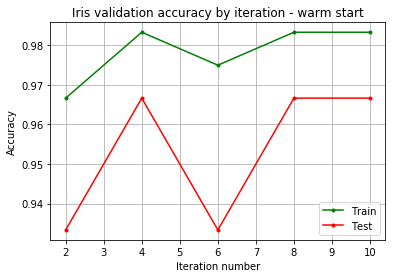

In [33]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

# get accuracy and iteration number
iters_proxy = %sql SELECT metrics_iters FROM iris_model_summary;
train_accuracy_proxy = %sql SELECT training_metrics FROM iris_model_summary;
test_accuracy_proxy = %sql SELECT validation_metrics FROM iris_model_summary;

# get number of points
num_points_proxy = %sql SELECT array_length(metrics_iters,1) FROM iris_model_summary;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
train_accuracy = np.array(train_accuracy_proxy).reshape(num_points)
test_accuracy = np.array(test_accuracy_proxy).reshape(num_points)

#plot
plt.title('Iris validation accuracy by iteration - warm start')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(iters, train_accuracy, 'g.-', label='Train')
plt.plot(iters, test_accuracy, 'r.-', label='Test')
plt.legend()

1 rows affected.
1 rows affected.


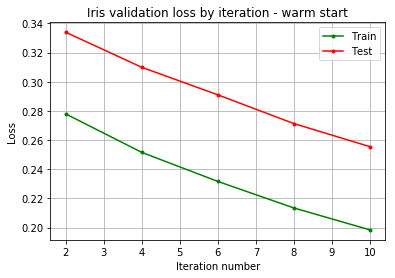

In [34]:
# get loss
train_loss_proxy = %sql SELECT training_loss FROM iris_model_summary;
test_loss_proxy = %sql SELECT validation_loss FROM iris_model_summary;

# reshape to np arrays
train_loss = np.array(train_loss_proxy).reshape(num_points)
test_loss = np.array(test_loss_proxy).reshape(num_points)

#plot
plt.title('Iris validation loss by iteration - warm start')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(iters, train_loss, 'g.-', label='Train')
plt.plot(iters, test_loss, 'r.-', label='Test')
plt.legend()

<a id="transfer_learn"></a>
# Transfer learning

<a id="load2"></a>
# 1. Define and load model architecture with some layers frozen
Here we want to start with initial weights from a pre-trained model rather than training from scratch.  We also want to use a model architecture with the earlier feature layer(s) frozen to save on training time.  The example below is somewhat contrived but gives you the idea of the steps.

First define a model architecture with the 1st hidden layer frozen:

In [35]:
model_transfer = Sequential()
model_transfer.add(Dense(10, activation='relu', input_shape=(4,), trainable=False))
model_transfer.add(Dense(10, activation='relu'))
model_transfer.add(Dense(3, activation='softmax'))
    
model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 143
Non-trainable params: 50
_________________________________________________________________


In [36]:
model_transfer.to_json()

'{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": false, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_5", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10

Load transfer model into model architecture table

In [37]:
%%sql
SELECT madlib.load_keras_model('model_arch_library',  -- Output table,                      
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": false, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Maria',               -- Name
                               'A transfer model'     -- Descr
);

SELECT model_id, model_arch, name, description FROM model_arch_library ORDER BY model_id;

1 rows affected.
2 rows affected.


model_id,model_arch,name,description
1,"{u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_1', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'dtype': u'float32', u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'batch_input_shape': [None, 4], u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_2', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_3', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'softmax', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}",Sophie,A simple model
2,"{u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_2', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'dtype': u'float32', u'activation': u'relu', u'trainable': False, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'batch_input_shape': [None, 4], u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_3', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_4', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'softmax', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}",Maria,A transfer model


<a id="train2"></a>
# 2. Train transfer model

Fetch the weights from a previous MADlib run.  (Normally these would be downloaded from a source that trained the same model architecture on a related dataset.)

In [38]:
%%sql
UPDATE model_arch_library 
SET model_weights = iris_model.model_weights 
FROM iris_model 
WHERE model_arch_library.model_id = 2;

1 rows affected.


[]

Now train the model using the transfer model and the pre-trained weights:

In [39]:
%%sql
DROP TABLE IF EXISTS iris_model, iris_model_summary;

SELECT madlib.madlib_keras_fit('iris_train_packed',   -- source table
                               'iris_model',          -- model output table
                               'model_arch_library',  -- model arch table
                                2,                    -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] $$,  -- compile_params
                                $$ batch_size=5, epochs=3 $$,  -- fit_params
                                10,                   -- num_iterations
                                FALSE,                -- use GPUs
                                'iris_test_packed',   -- validation dataset
                                2                     -- metrics compute frequency
                              );

Done.
1 rows affected.


madlib_keras_fit
""


In [40]:
%%sql
SELECT * FROM iris_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
iris_train_packed,iris_model,class_text,attributes,model_arch_library,2,"loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']","batch_size=5, epochs=3",10,iris_test_packed,2,None,None,madlib_keras,0.7900390625,2019-12-18 18:09:32.439417,2019-12-18 18:09:34.068824,"[0.853152990341187, 0.990938901901245, 1.11821985244751, 1.24195981025696, 1.62932586669922]",1.17-dev,3,"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",character varying,1.0,[u'accuracy'],0.983333349228,0.155750438571,"[0.983333349227905, 0.983333349227905, 0.975000023841858, 0.975000023841858, 0.983333349227905]","[0.187174424529076, 0.17763115465641, 0.169175431132317, 0.161857321858406, 0.155750438570976]",0.966666638851,0.211615949869,"[0.966666638851166, 0.966666638851166, 0.966666638851166, 0.966666638851166, 0.966666638851166]","[0.244408145546913, 0.234545931220055, 0.225818797945976, 0.218266576528549, 0.211615949869156]","[2, 4, 6, 8, 10]"


Note loss picks up from where the last training left off:

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


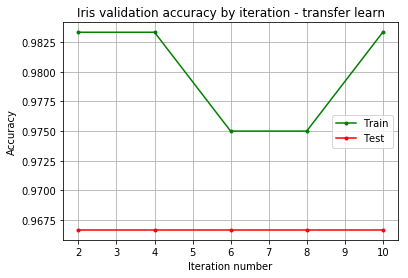

In [41]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

# get accuracy and iteration number
iters_proxy = %sql SELECT metrics_iters FROM iris_model_summary;
train_accuracy_proxy = %sql SELECT training_metrics FROM iris_model_summary;
test_accuracy_proxy = %sql SELECT validation_metrics FROM iris_model_summary;

# get number of points
num_points_proxy = %sql SELECT array_length(metrics_iters,1) FROM iris_model_summary;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
train_accuracy = np.array(train_accuracy_proxy).reshape(num_points)
test_accuracy = np.array(test_accuracy_proxy).reshape(num_points)

#plot
plt.title('Iris validation accuracy by iteration - transfer learn')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(iters, train_accuracy, 'g.-', label='Train')
plt.plot(iters, test_accuracy, 'r.-', label='Test')
plt.legend()

1 rows affected.
1 rows affected.


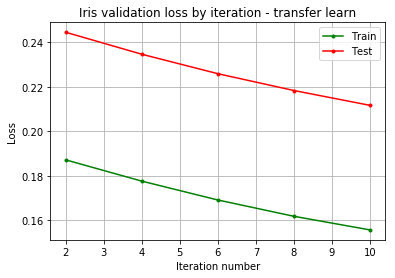

In [42]:
# get loss
train_loss_proxy = %sql SELECT training_loss FROM iris_model_summary;
test_loss_proxy = %sql SELECT validation_loss FROM iris_model_summary;

# reshape to np arrays
train_loss = np.array(train_loss_proxy).reshape(num_points)
test_loss = np.array(test_loss_proxy).reshape(num_points)

#plot
plt.title('Iris validation loss by iteration - transfer learn')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(iters, train_loss, 'g.-', label='Train')
plt.plot(iters, test_loss, 'r.-', label='Test')
plt.legend()